<a href="https://colab.research.google.com/github/Permanganant/AI-in-Medicine-I/blob/main/Brain_Tissue_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI in Medicine I - Practical 2: Brain Tissue Segmentation

Segmentation of different tissues from MRI scans of the brain is an important step for further downstream applications such as disease prediction, classification or brain age estimation.

The goal of the coursework is to implement classical and deep learning approaches for segmentation of different tissue types in MRI scans of the brain, i.e., background, cerebrospinal fluid (CSF), white matter (WM), and gray matter (GM). We provide data from a total of 652 healthy subjects, that is split into different development sets and a hold-out test set on which you will evaluate your final segmentation accuracy.
Each approach will require a processing pipeline with different components that you will need to implement using methods that were discussed in the lectures and tutorials. There are three dedicated parts in the Jupyter notebook for each approach which contain some detailed instructions and some helper code.

**Make sure to select the correct runtime when working in Google Colab (GPU)**

## Downloading the Data

In [ ]:
!wget -q --show-progress https://www.dropbox.com/s/w9njau9t6rrheel/brainage-data.zip
!unzip -qq -o brainage-data.zip
!wget -q --show-progress https://www.dropbox.com/s/f5mt8p9pkszff3x/brainage-testdata.zip
!unzip -qq -o brainage-testdata.zip


brainage-data.zip.2 100%[===================>] 446,94M  21,7MB/s    in 20s     
brainage-testdata.z 100%[===================>]   1,49K  --.-KB/s    in 0s      


In [ ]:
!pip install tensorboard

### Imports

In [ ]:
import os
import glob
import random
from argparse import Namespace
from functools import partial
from multiprocessing import Pool
from numbers import Number
from typing import Any, Dict
from typing import List, Tuple
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


def seed_everything(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False


def mean_absolute_error(preds: Tensor, targets: Tensor) -> float:
    """Compute the mean absolute error between predictions and targets"""
    return (preds.view(-1) - targets.view(-1)).abs().mean().item()


class TensorboardLogger(SummaryWriter):
    def __init__(
        self,
        log_dir: str = None,
        config: Namespace = None,
        enabled: bool = True,
        comment: str = '',
        purge_step: int = None,
        max_queue: int = 10,
        flush_secs: int = 120,
        filename_suffix: str = ''
    ):
        self.enabled = enabled
        if self.enabled:
            super().__init__(
                log_dir=log_dir,
                comment=comment,
                purge_step=purge_step,
                max_queue=max_queue,
                flush_secs=flush_secs,
                filename_suffix=filename_suffix
            )
        else:
            return

        # Add config
        if config is not None:
            self.add_hparams(
                {k: v for k, v in vars(config).items() if isinstance(
                    v, (int, float, str, bool, torch.Tensor))},
                {}
            )

    def log(self, data: Dict[str, Any], step: int) -> None:
        """Log each entry in data as its corresponding data type"""
        if self.enabled:
            for k, v in data.items():
                # Scalars
                if isinstance(v, Number):
                    self.add_scalar(k, v, step)

                # Images
                elif (isinstance(v, np.ndarray) or isinstance(v, torch.Tensor)) and len(v.shape) >= 3:
                    if len(v.shape) == 3:
                        self.add_image(k, v, step)
                    elif len(v.shape) == 4:
                        self.add_images(k, v, step)
                    else:
                        raise ValueError(f'Unsupported image shape: {v.shape}')

                # Matplotlib figures
                elif isinstance(v, plt.Figure):
                    self.add_figure(k, v, step)

                else:
                    raise ValueError(f'Unsupported data type: {type(v)}')


def load_nii(path: str, dtype: str = 'float32') -> np.ndarray:
    """Load an MRI scan from disk and convert it to a given datatype

    :param path: Path to file
    :param dtype: Target dtype
    :return img: Loaded image. Shape (H, W, D)
    """
    return nib.load(path).get_fdata().astype(np.dtype(dtype))


def load_segmentations(paths: str):
    """Load all segmentations and associated subject_ids"""
    filenames, segmentations = [], []
    for im in tqdm(paths):
        id = im.split('_brain_')[0].split('/')[-1].split('-')[1].split('_')[0]
        segmentations.append(load_nii(im))
        filenames.append(id)
    return filenames, np.array(segmentations)


def plot_segmentations(im: np.ndarray, seg: np.ndarray, i: int = 65, title: str = None):
    fig, ax = plt.subplots(2, 3, figsize=(20, 10))

    col = 2
    ax[0, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[..., i], k=3),
                 alpha=0.5 * (np.rot90(seg[..., i] > 0, k=3)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[..., i], k=3), cmap='gray')
    ax[0, col].set_title('Axial')

    k = 1
    col = 0
    ax[0, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[i, ...], k=k),
                 alpha=0.5 * (np.rot90(seg[i, ...] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[i, ...], k=k), cmap='gray')
    ax[0, col].set_title('Sagittal')

    col = 1
    ax[0, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].imshow(np.rot90(seg[:, i, :], k=k),
                 alpha=0.5 * (np.rot90(seg[:, i, :] > 0, k=k)),
                 interpolation=None, cmap='jet')
    ax[1, col].imshow(np.rot90(im[:, i, :], k=k), cmap='gray')
    ax[0, col].set_title('Coronal')

    if title is not None:
        # plt.set_title(title)
        fig.suptitle(title, fontsize=16)

    plt.tight_layout()
    plt.show()



%load_ext tensorboard
%load_ext autoreload
%autoreload 2

## Getting started and familiarise ourselves with the data

We provide the data of 652 subjects from which we use 522 for training, 65 for validation, and the rest of 65 for testing your final model.

## Imaging data
Let's check out the imaging data that is available for each subject.

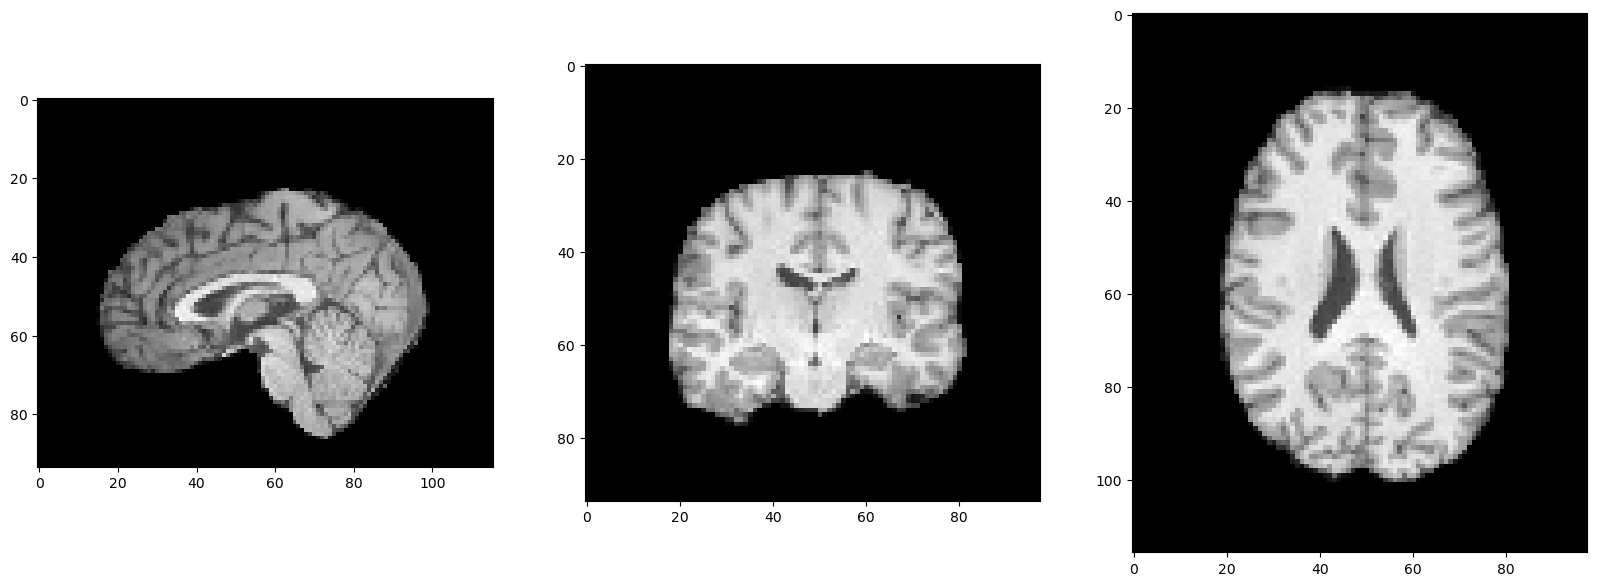

In [ ]:
file = './data/brain_age/images/sub-CC110033_T1w_unbiased.nii.gz'

image = nib.load(file).get_fdata()

f, axarr = plt.subplots(1, 3, figsize=(20, 10))
H, W, D = image.shape
axarr[0].imshow(np.flip(image[H // 2, :, :].T, axis=0), cmap='gray')
axarr[1].imshow(np.flip(image[:, W // 2, :].T, axis=0), cmap='gray')
axarr[2].imshow(image[:, :, D // 2].T, cmap='gray')
plt.show()

## Data loading and visualization

Let's first load all the data and make a tranin/val/test split

In [ ]:
paths = sorted(glob.glob('data/brain_age/segs_refs/*'))
filenames, segmentations = load_segmentations(paths)

100%|████████████████████████████████████████| 652/652 [00:02<00:00, 308.83it/s]


In [ ]:
np.random.seed(10282022)

all_keys = np.asarray(range(len(filenames)))
ratio_test = int(0.1 * len(all_keys))  # 10% val; 10% test
val_keys = np.random.choice(all_keys, 2 * ratio_test, replace=False)
test_keys = np.random.choice(val_keys, ratio_test, replace=False)

train_files, val_files, test_files = [], [], []
segmentations_train, segmentations_val, segmentations_test =  [],  [], []
for scan_id in tqdm(all_keys):
  scan = f'data/brain_age/images/sub-{filenames[scan_id]}_T1w_unbiased.nii.gz'
  seg = segmentations[scan_id]
  if scan_id in test_keys:
      test_files.append(scan)
      segmentations_test.append(seg)
  elif scan_id in val_keys:
      val_files.append(scan)
      segmentations_val.append(seg)
  else:
      train_files.append(scan)
      segmentations_train.append(seg)
print(f'{len(train_files)} train files')
print(f'{len(val_files)} val files')
print(f'{len(test_files)} test files')

100%|█████████████████████████████████████| 652/652 [00:00<00:00, 330116.64it/s]

522 train files
65 val files
65 test files


Let's visualize one validations sample

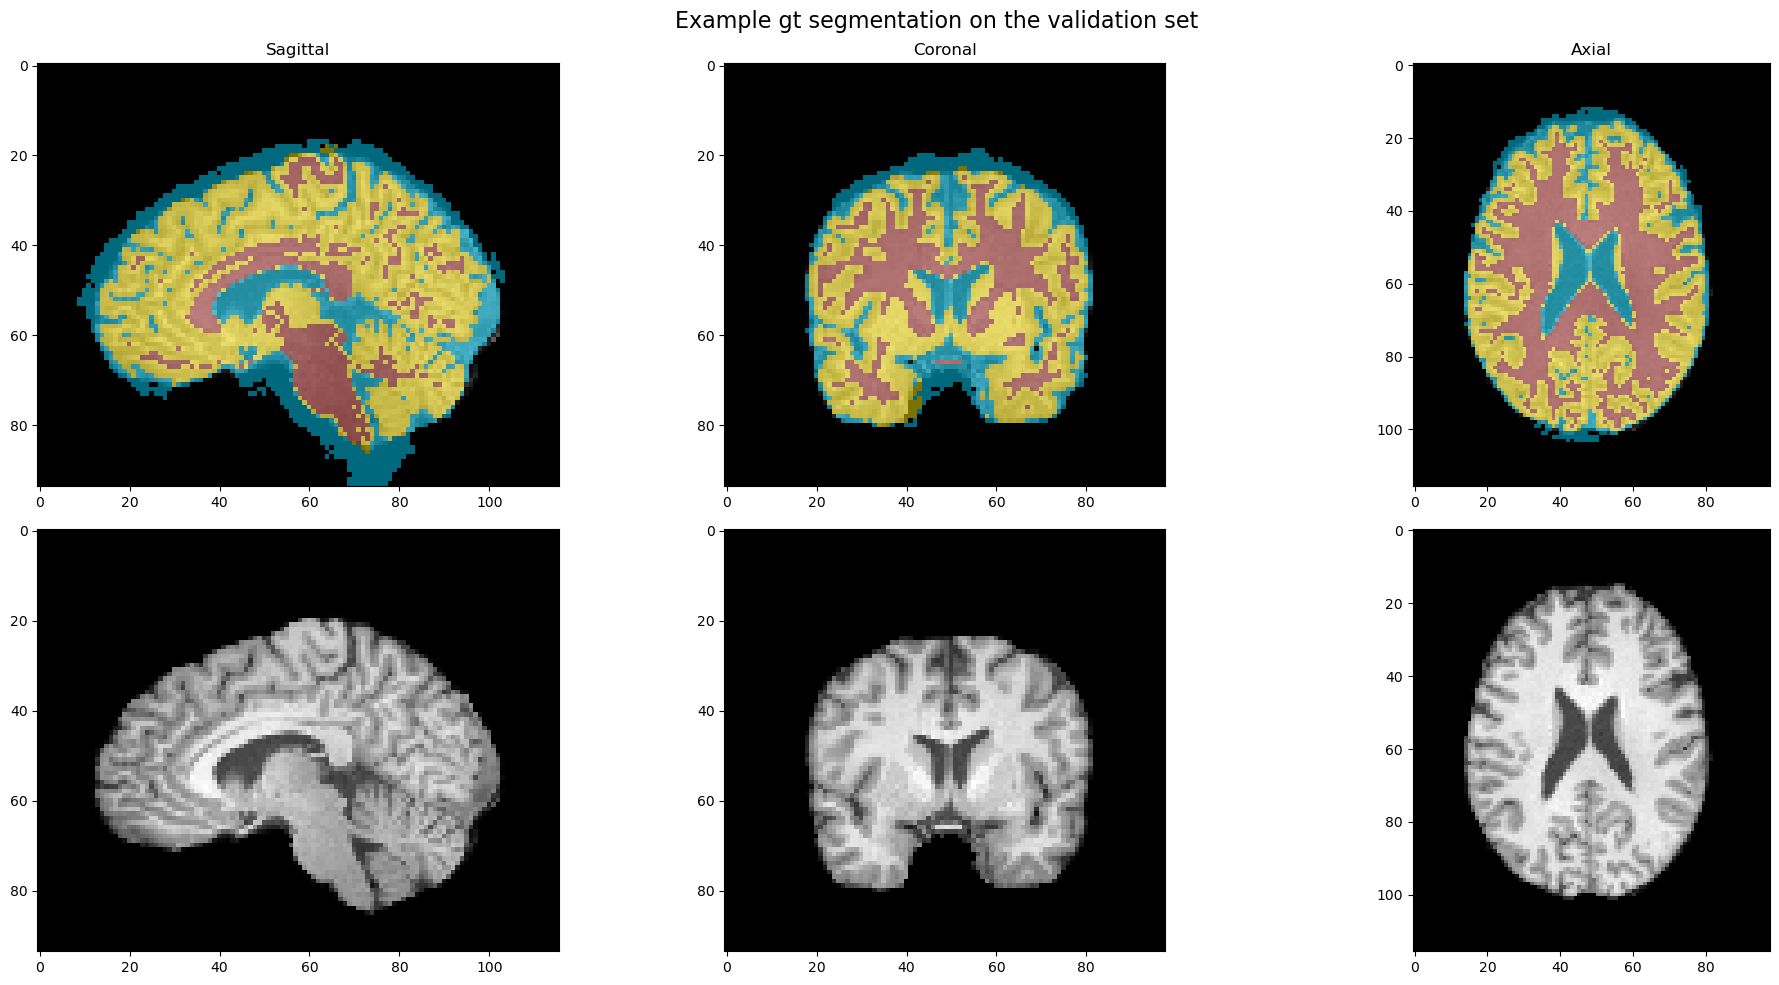

In [ ]:
im = load_nii(val_files[0])
plot_segmentations(im, segmentations_val[0], i=47, title='Example gt segmentation on the validation set')

# Task 1: Evaluation and Visualization

**Q1a**. We first have to define how good our predicted segmentations are. Implement the evaluation functions below.

In [ ]:
# The Dice similarity coefficient is widely used for evaluating image segmentation alogrithms.
# Implement a method that computes the patient-wise Dice score, precision, and recall (mean and std) for the test dataset.
# Hint: Don't forget that there are multiple classes.
# --------------------------- ADD YOUR CODE HERE ------------------------------
def Dice(predictions, gt):
    dice_per_class = []
    num_classes = np.unique(gt)

    for k in num_classes:
        intersection = np.sum((predictions == k) & (gt == k))
        union = np.sum(predictions == k) + np.sum(gt == k)
        dice_per_class.append((intersection *2) / (union + 1e-5))  # Adding a small value to avoid division by zero

    mean = [np.mean(dice_per_class),dice_per_class[0],dice_per_class[1],dice_per_class[2],dice_per_class[3]]
    std = np.std(dice_per_class)

    return mean, std

def precision(predictions, gt):
    precision_call = []
    num_classes = np.unique(gt)

    for k in num_classes:
        # True Positives
        TP = np.sum((predictions == k) & (gt == k))

        # False Positives
        FP = np.sum((predictions == k) & (gt != k))

        precision_call.append(TP / (TP + FP + 1e-5))  # Adding a small value to avoid division by zero

    mean = [np.mean(precision_call), precision_call[0], precision_call[1], precision_call[2], precision_call[3]]
    std = np.std(precision_call)

    return mean, std

def recall(predictions, gt):
  recall_per_class = []
  num_classes = np.unique(gt)

  for k in num_classes:
      # True Positives for the current class
      TP = np.sum((predictions[gt == k] == k).astype(int))

      # False Negatives for the current class
      FN = np.sum((predictions[gt == k] != k).astype(int))

      # Calculate Recall for the current class
      recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
      recall_per_class.append(recall)

  mean = [np.mean(recall_per_class),recall_per_class[0],recall_per_class[1],recall_per_class[2],recall_per_class[3]]
  std = np.std(recall_per_class)


  return mean, std

# ----------------------------------- END -------------------------------------

**Q1b**. Next, we want to visualize the best- and worst-performing samples in the test set. Implement a function that evaluates the entire test dataset and outputs the index of the best and worst performing samples according to the Dice coefficient.

In [ ]:
def get_best_and_worst_ids(predictions, gt):
    best_id, worst_id = -1, -1
    best_performance, worst_performance = None, None
    fom = []
    std_arr = []

    for pred_elem, gt_elem in zip(predictions, gt):
        mean, std = Dice(pred_elem, gt_elem)
        fom.append(abs(mean[0] / std))  # Use only the overall mean in the figure of merit calculation
        std_arr.append(std)

    best_performance = np.max(fom)
    best_id = np.where(fom == best_performance)[0][0]
    best_performance = std_arr[best_id] * best_performance

    worst_performance = np.min(fom)
    worst_id = np.where(fom == worst_performance)[0][0]
    worst_performance = std_arr[worst_id] * worst_performance

    return {
        'best_id': best_id,
        'best_performance': best_performance,
        'worst_id': worst_id,
        'worst_performance': worst_performance
    }


def visualize_best_and_worst_samples(predictions, gt, i_best=47, i_worst=47):
    return_dict = get_best_and_worst_ids(predictions, gt)

    best_id = return_dict['best_id']
    best_dice_mean = Dice(predictions[best_id], gt[best_id])[0][0]  # Use only the overall mean

    plot_segmentations(load_nii(test_files[best_id]), predictions[best_id], i=i_best,
                       title=f'Best prediction on the test set (Dice: {best_dice_mean:.2f})')

    worst_id = return_dict['worst_id']
    worst_dice_mean = Dice(predictions[worst_id], gt[worst_id])[0][0]  # Use only the overall mean

    plot_segmentations(load_nii(test_files[worst_id]), predictions[worst_id], i=i_worst,
                       title=f'Worst prediction on the test set (Dice: {worst_dice_mean:.2f})')

**Q1c**. Given a set of predictions for a number of models, create a summary figure of your choice (e.g. table, bar plot) which visualizes all of the metric values. Visualize multiple metrics (Dice coefficient, precision, and recall), each computed for every tissue type. A sample dictionary is provided below.

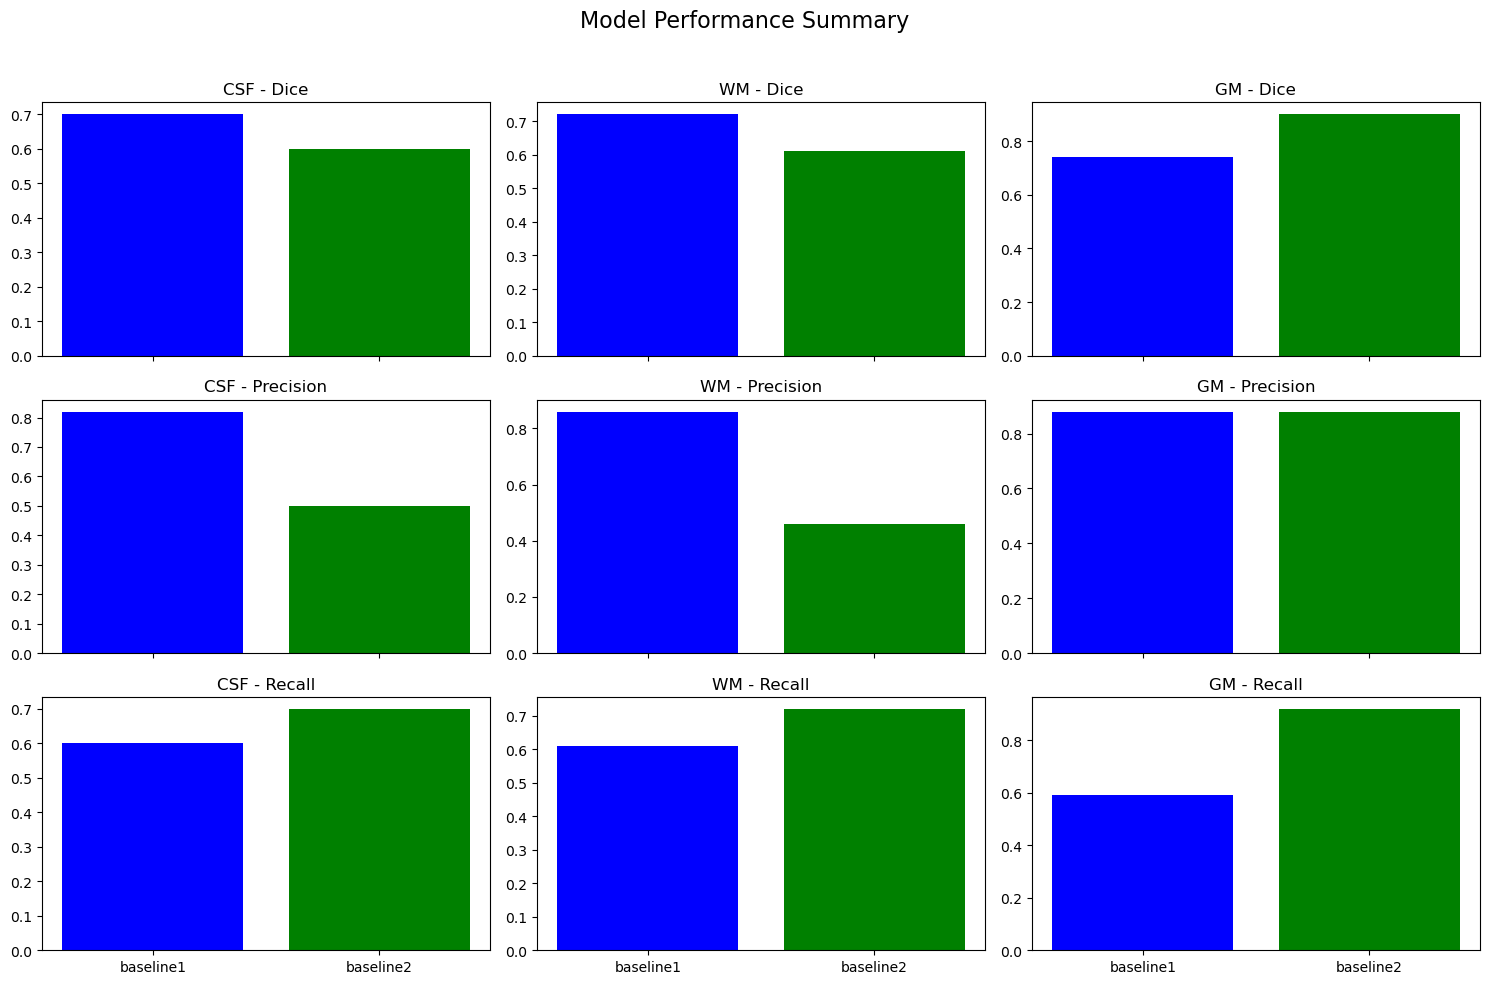

In [ ]:
import numpy as np

def get_results_dictionary(predictions, gt):
    results_dict = {}

    counter = 1
    dice_means_1 = []
    dice_means_2 = []
    dice_means_3 = []

    precision_means_1 = []
    precision_means_2 = []
    precision_means_3 = []

    recall_means_1 = []
    recall_means_2 = []
    recall_means_3 = []

    for labels, gt_volume in zip(predictions, gt):
        dice_, _ = Dice(labels, gt_volume.astype(int))
        precision_, _ = precision(labels.astype(int), gt_volume.astype(int))
        recall_, _ = recall(labels.astype(int), gt_volume.astype(int))

        dice_means_1.append((dice_[2]))
        precision_means_1.append((precision_[2]))
        recall_means_1.append((recall_[2]))

        dice_means_2.append((dice_[3]))
        precision_means_2.append((precision_[3]))
        recall_means_2.append((recall_[3]))

        dice_means_3.append((dice_[4]))
        precision_means_3.append((precision_[4]))
        recall_means_3.append((recall_[4]))



        counter += 1

    # Calculate overall means
    overall_means = {
        'CSF': {'dice': np.mean(dice_means_1), 'precision': np.mean(precision_means_1), 'recall': np.mean(recall_means_1)},
        'WM': {'dice': np.mean(dice_means_2), 'precision': np.mean(precision_means_2), 'recall': np.mean(recall_means_2)},
        'GM': {'dice': np.mean(dice_means_3), 'precision': np.mean(precision_means_3), 'recall': np.mean(recall_means_3)},
    }

    results_dict = overall_means

    return results_dict




def plot_results_summary(results_dict: Dict[str, Dict[str, Dict[str, float]]]) -> None:
    metrics = ['dice', 'precision', 'recall']
    tissue_types = list(next(iter(results_dict.values())).keys())
    num_models = len(results_dict)

    fig, axs = plt.subplots(len(metrics), len(tissue_types), figsize=(15, 10), sharex=True)
    fig.suptitle('Model Performance Summary', fontsize=16)

    for i, metric in enumerate(metrics):
        for j, tissue_type in enumerate(tissue_types):
            values = [results_dict[model][tissue_type][metric] for model in results_dict]
            axs[i, j].bar(range(num_models), values, color=['blue', 'green', 'red', 'purple', 'orange'])
            axs[i, j].set_xticks(range(num_models))
            axs[i, j].set_xticklabels(results_dict.keys())
            axs[i, j].set_title(f'{tissue_type} - {metric.capitalize()}')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Example usage:
sample_results = {
    'baseline1': {
        'CSF': {'dice': 0.7, 'precision': 0.82, 'recall': 0.6},
        'WM': {'dice': 0.72, 'precision': 0.86, 'recall': 0.61},
        'GM': {'dice': 0.74, 'precision': 0.88, 'recall': 0.59},
    },
    'baseline2': {
        'CSF': {'dice': 0.6, 'precision': 0.5, 'recall': 0.7},
        'WM': {'dice': 0.61, 'precision': 0.46, 'recall': 0.72},
        'GM': {'dice': 0.9, 'precision': 0.88, 'recall': 0.92},
    }
}

plot_results_summary(sample_results)

# Task 2: Unsupervised segmentation

The first approach aims to segment the brain tissues, including grey matter (GM), white matter (WM), cerebrospinal fluid (CSF), and background using unsupervised classical machine learning techniques.

Different unsupervised techniques to leverage the different intensity profile of the tissues should be explored.

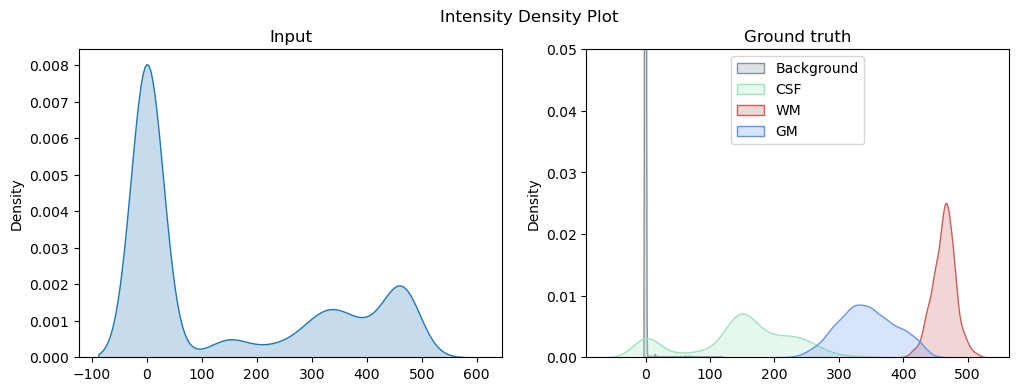

In [ ]:
slice_id = 0
im_ = load_nii(val_files[slice_id])[:,:,47].flatten()
seg_ = segmentations_val[slice_id][:,:,47].flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=False)
fig.suptitle('Intensity Density Plot')

sns.kdeplot(im_, ax=axes[0], fill=True)
axes[0].set_title('Input')

sns.kdeplot(im_[np.argwhere(seg_ == 0)][:, 0], ax=axes[1], fill=True, color='#85929E', label='Background', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 1)][:, 0], ax=axes[1], fill=True, color='#9FE2BF', label='CSF', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 3)][:, 0], ax=axes[1], fill=True, color='#CD5C5C', label='WM', legend=True)
sns.kdeplot(im_[np.argwhere(seg_ == 2)][:, 0], ax=axes[1], fill=True, color='#6495ED', label='GM', legend=True)
axes[1].set_ylim(0, 0.05)
axes[1].set_title('Ground truth')
plt.legend(loc=9, labels=['Background', 'CSF', 'WM', 'GM'])

## Unsupervised Learning

Here, you should experiment with different *classical* unsupervised machine learning methods, e.g., clustering, density estimation, etc... (at least two different methods). Hint: sklearn has implementations of unsupervised methods

**HINT**: You can predict the different classes of intensities even without any training!

**HINT**: You can evaluate every volume slice-by-slice if the whole volume does not fit in the memory.

#### QUESTION Q2a.
Implement an unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 1.

In [ ]:
from sklearn.metrics import pairwise_distances_argmin_min

def rearrange_labels(seg_mask, gt_volume):
    unique_labels = np.unique(seg_mask)
    rearranged_labels = np.zeros_like(seg_mask)

    for label in unique_labels:
        # Find the ground truth label that maximizes the overlap
        gt_label = np.argmax(np.bincount(gt_volume[seg_mask == label]))

        # Assign the rearranged label to the corresponding cluster
        rearranged_labels[seg_mask == label] = gt_label

    return rearranged_labels

In [ ]:
dice_scores = []
pred_seg_1 = []

for file_path, gt_volume in zip(test_files, segmentations_test):

    kmeans = KMeans(n_clusters=4, random_state=42, n_init="auto")
    # Load the test NIfTI file
    test_nifti_data = nib.load(file_path)
    test_volume = test_nifti_data.get_fdata()

    # Reshape the 3D volume to a column vector
    test_volume_2d = test_volume.flatten().reshape(-1, 1)

    # Fit KMeans model
    kmeans.fit(test_volume_2d)

    # Apply unsupervised segmentation
    labels = kmeans.predict(test_volume_2d)
    seg_mask = labels.reshape(test_volume.shape)


    # Rearrange the labels to match ground truth using the Hungarian algorithm
    rearranged_labels = rearrange_labels(seg_mask, gt_volume.astype(int))
    #pred_seg_1.append(rearranged_labels)i


    # Evaluate the segmentation using Dice coefficient

    pred_seg_1.append(rearranged_labels)

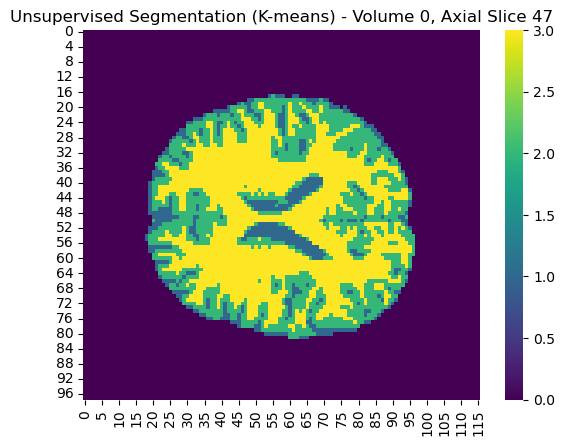

In [ ]:
sns_plot_1 = sns.heatmap(pred_seg_1[0][:, :, 47], cmap="viridis", cbar=True)
plt.title('Unsupervised Segmentation (K-means) - Volume 0, Axial Slice 47')
plt.show()

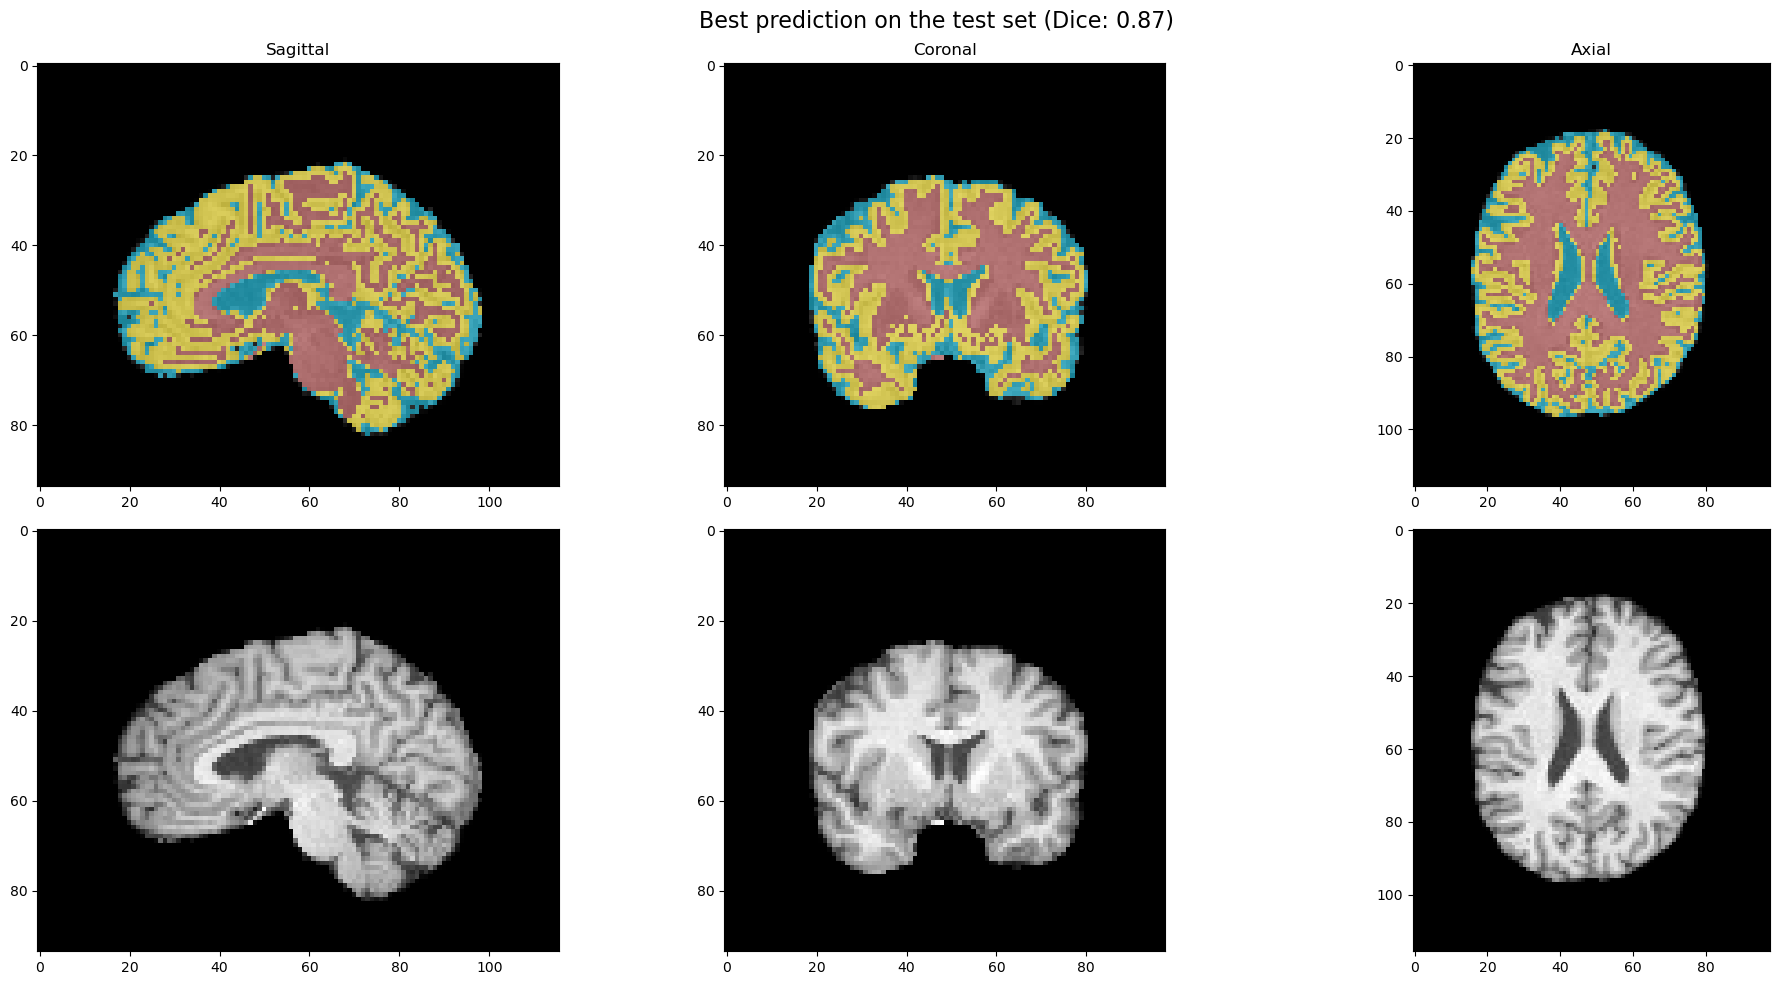

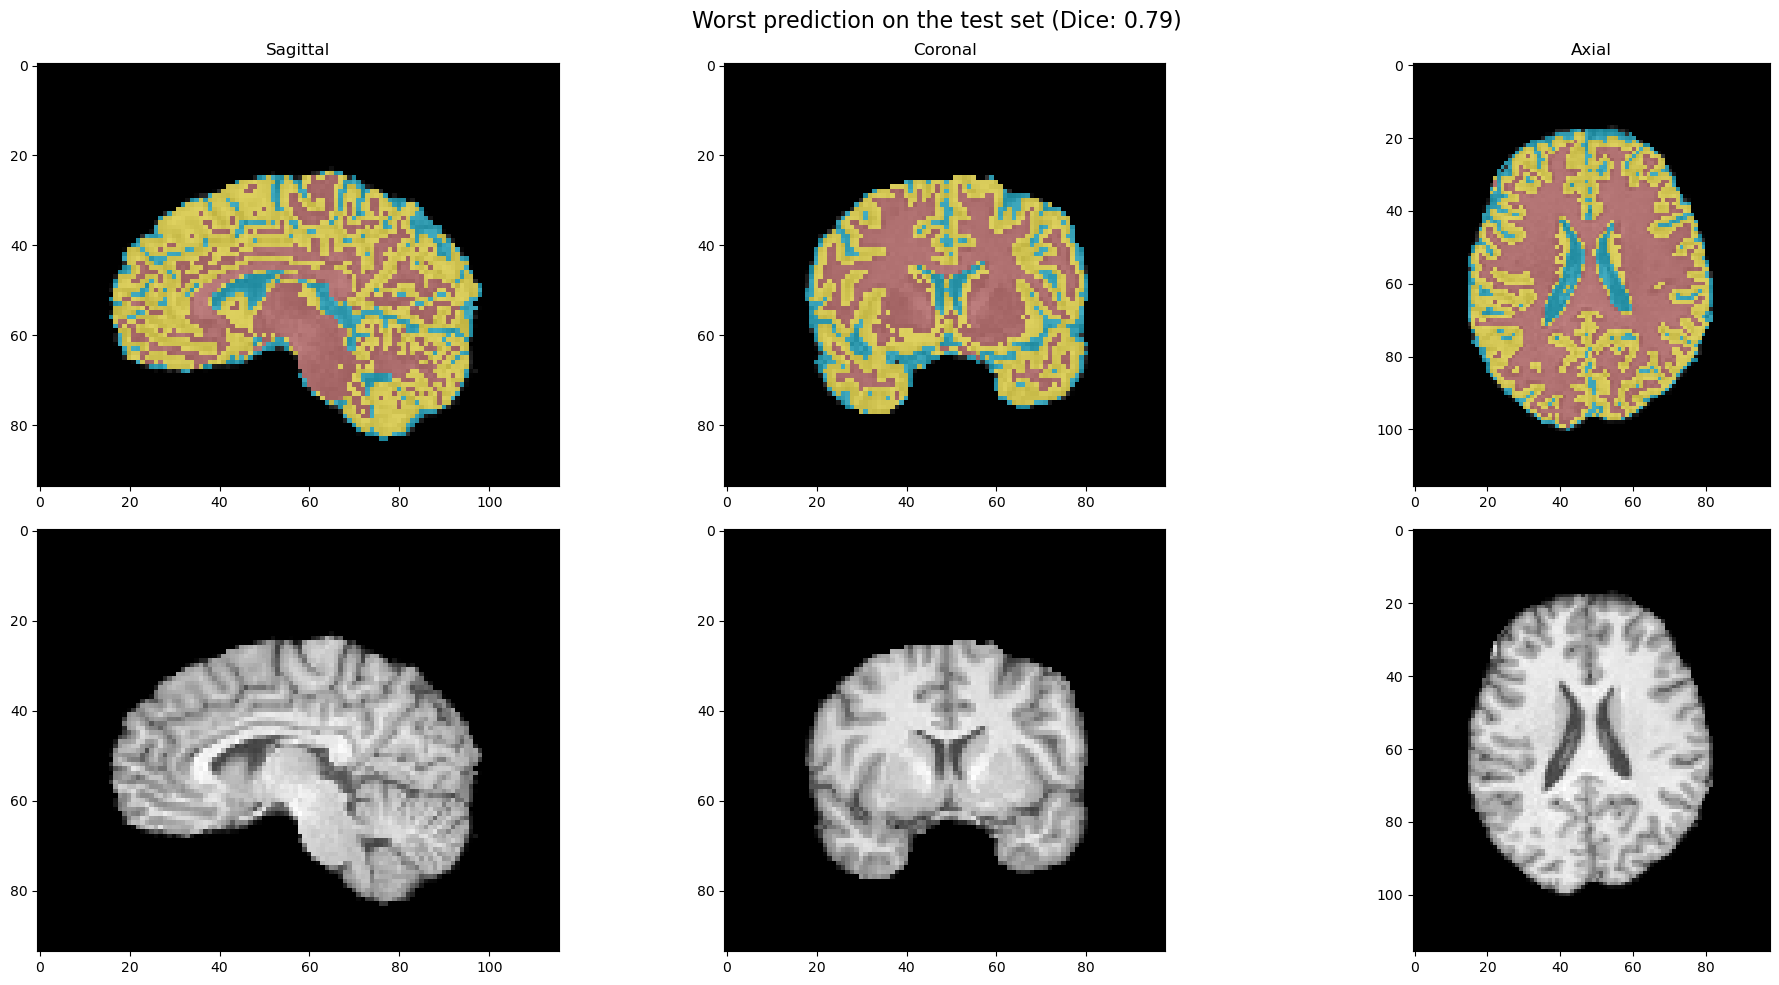

In [ ]:
# Visualize the best and worst predictions on the test set for method 1
visualize_best_and_worst_samples(pred_seg_1,segmentations_test)

#### QUESTION Q2b.
Implement a second unsupervised learning method of your choice.
Evaluate the Dice scores (separately for every tissue type) for the whole test set using method 2.

In [ ]:
def multi_otsu_threshold_3d(data, classes):

    segmented_volumes = []
    segmented_volume = np.zeros_like(data)


    for z in range(data.shape[2]):
        unique_values = np.unique(data[:, :, z])

        if len(unique_values) > 4:

            thresholds = np.sort(threshold_multiotsu(data[:, :, z], classes=classes))
            segmented_slice = np.digitize(data[:, :, z], bins=thresholds)
            segmented_volume[:, :, z] = segmented_slice
        else:
            segmented_volume[:, :, z] = data[:, :, z]

    segmented_volumes.append(segmented_volume)

    return segmented_volumes

dice_scores = []
pred_seg_2=[]
# Example usage with one volume
for file_path, gt_volume in zip(test_files, segmentations_test):
    # Load the test NIfTI file
    test_nifti_data = nib.load(file_path)
    test_volume = test_nifti_data.get_fdata()

    # Ensure that the flattened data is contiguous in memory
    test_volume_2d = np.ascontiguousarray(test_volume)
    segmented_volumes = multi_otsu_threshold_3d(test_volume_2d, 4)

    #labels = kmeans.labels_
    #seg_mask = labels.reshape(test_volume.shape)
    pred_seg_2.append(segmented_volumes)

In [ ]:
pred_seg_2 = np.array(pred_seg_2).squeeze(1)

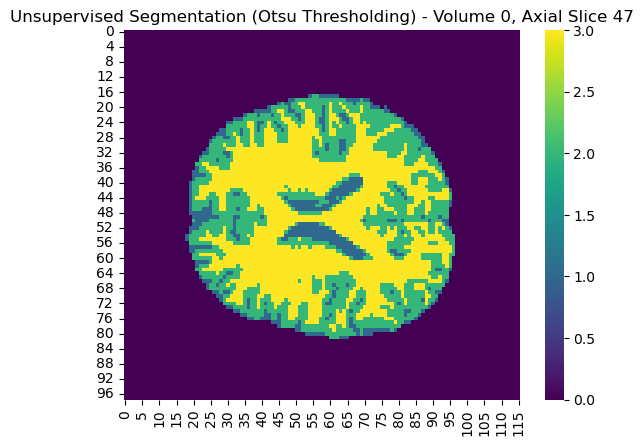

In [ ]:
sns_plot_2 = sns.heatmap(pred_seg_2[0][:, :, 47], cmap="viridis", cbar=True)
plt.title('Unsupervised Segmentation (Otsu Thresholding) - Volume 0, Axial Slice 47')
plt.show()

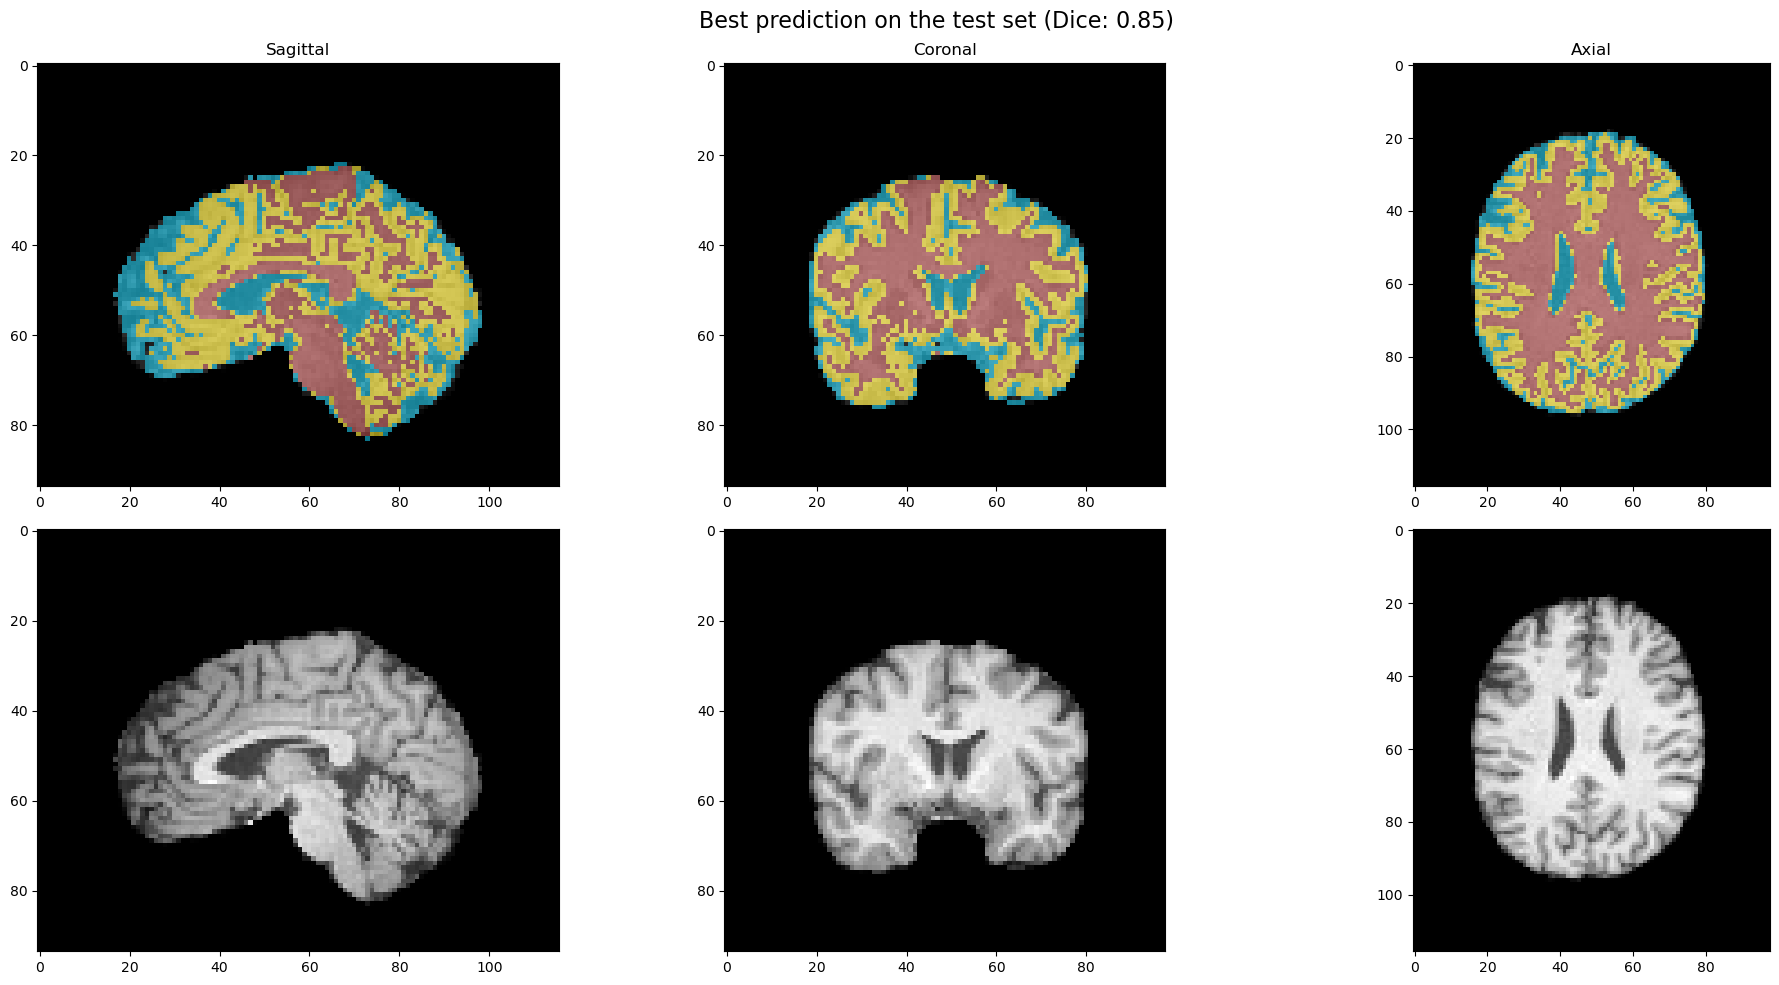

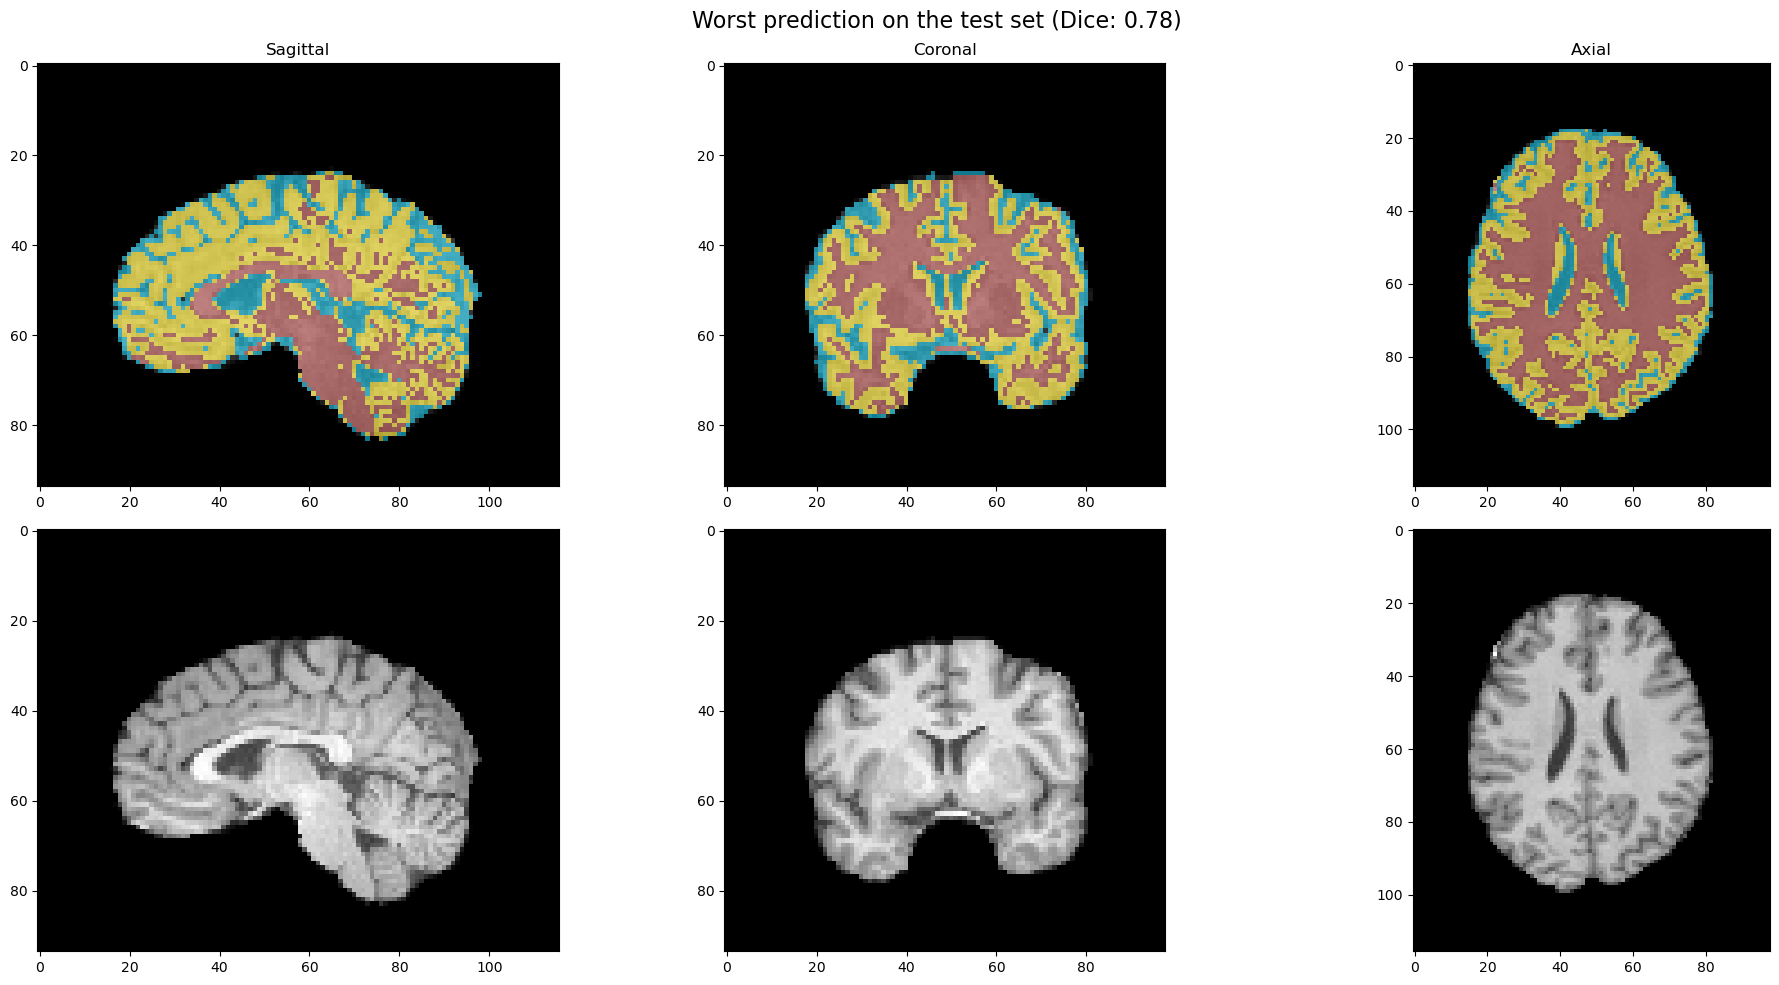

In [ ]:
visualize_best_and_worst_samples(pred_seg_2,segmentations_test,i_best=48,i_worst = 48)

# Task 3: Deep supervised segmentation

Deep Learning (DL) methods achieve state-of-the-art results in many (medical) image analyzis applications, including segmentation. Here, you will implement and train a DL method to segment CSF, WM, GM, and background in brain MRI.

First, let's have a look at the individual channels of the segmentations.

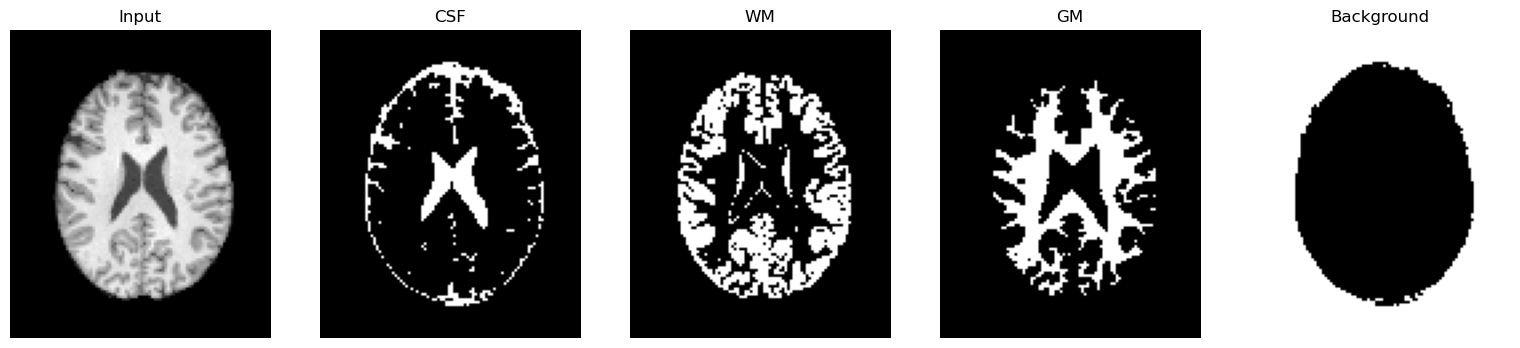

In [ ]:
import matplotlib.pyplot as plt
import copy
im = load_nii(val_files[0])
csf, wm, gm, background = np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape), np.zeros(im.shape)
csf[segmentations_val[0]==1] = 1
wm[segmentations_val[0]==2] = 1
gm[segmentations_val[0]==3] = 1
background[segmentations_val[0]==0]=1
elements = [im, csf, wm, gm, background]
titles = ['Input', 'CSF', 'WM', 'GM', 'Background']
diffp, axarr = plt.subplots(1, len(elements), gridspec_kw={'wspace': 0, 'hspace': 0})
diffp.set_size_inches(len(elements) * 4, 4)
for idx_arr in range(len(axarr)):
    axarr[idx_arr].axis('off')
    el = np.squeeze(elements[idx_arr][:,:,47])
    axarr[idx_arr].imshow(el.T, cmap='gray')
    axarr[idx_arr].set_title(titles[idx_arr])

## DL-based segmentation

Define and train a U-Net for segmentation (use the train, val, and test splits defined above).

Feel free to choose:
* the number of layers
* the number of features within convolutional layers
* number of convolutions within each layer
* concatenation strategy
* ...

HINT: You can use pre-defined models, e.g., from torchvision, but train them from scratch (no pre-training)

In [ ]:
!pip install nibabel

In [ ]:
import torch
from torch.utils.data import Dataset
import nibabel as nib
import numpy as np
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import time

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, segmentation_data):
        self.file_paths = file_paths
        self.segmentation_data = segmentation_data

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):

        # Load and process the NIfTI file at the specified index

        nifti_data = nib.load(self.file_paths[idx])
        volume = nifti_data.get_fdata()

        # Ensure that the data is contiguous in memory
        volume_2d = np.ascontiguousarray(volume)

        # Convert to PyTorch tensors
        input_tensor = torch.from_numpy(volume_2d).float()

        # Load the corresponding segmentation mask from segmentation_data
        segmentation_mask = self.segmentation_data[idx]

        # Convert to PyTorch tensor with long type (assuming integer class labels)
        target_tensor = torch.from_numpy(np.ascontiguousarray(segmentation_mask)).long()

        # Return a tuple (input_tensor, target_tensor)
        return input_tensor, target_tensor


train_dataset = CustomDataset(train_files, np.array(segmentations_train))
val_dataset = CustomDataset(val_files, np.array(segmentations_val))
test_dataset = CustomDataset(val_files, np.array(segmentations_test))

In [ ]:
class UNet(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(UNet, self).__init__()


        # Pre-trained ResNet18 as the encoder
        resnet = models.resnet18(pretrained=True)
        # Remove the fully connected layer
        self.encoder = nn.Sequential(*list(resnet.children())[:-1])

        self.encoder[0] = nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Number of output channels for the decoder
        decoder_channels = [256, 128, 64, 8]

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, decoder_channels[0], kernel_size=2, stride=2),
            nn.BatchNorm2d(decoder_channels[0]),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.5),

            nn.ConvTranspose2d(decoder_channels[0], decoder_channels[1], kernel_size=2, stride=2),
            nn.BatchNorm2d(decoder_channels[1]),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),

            nn.ConvTranspose2d(decoder_channels[1], decoder_channels[2], kernel_size=2, stride=2),
            nn.BatchNorm2d(decoder_channels[2]),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),

            nn.ConvTranspose2d(decoder_channels[2], decoder_channels[3], kernel_size=2, stride=2),
            nn.BatchNorm2d(decoder_channels[3]),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3),

            nn.Conv2d(decoder_channels[3], num_classes, kernel_size=1)
        )

        # Resize function to match target size
        self.resize = nn.Upsample(size=(98, 116), mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        x = self.decoder(x)

        # Resize to match the target size
        x = self.resize(x)

        return x

In [ ]:
def extract_2d_slices(batch_3d,slice_index):
    # Assuming batch_3d is a tuple containing 3D volumes and labels
    volumes, targets = batch_3d
    # Assuming volumes is a 4D tensor with shape (batch_size, depth, height, width)
    batch_size, depth, height, width = volumes.size()

    # Randomly select a slice along the depth dimension

    slices = volumes[:, :, :,slice_index]
    target_slices = targets.clone()[:, :, :, slice_index]

    # You might want to normalize or preprocess the slices based on your requirements
    min_val = slices.min()
    max_val = slices.max()
    slices = (slices - min_val) / (max_val - min_val)


    return slices, target_slices

In [ ]:
# DataLoader for batching and shuffling
train_dataloader_3d = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader_3d = DataLoader(val_dataset, batch_size=50, shuffle=False)

num_classes = 4
input_channels = 1

# Model, loss function, and optimizer
model = UNet(num_classes, input_channels)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

/Users/mertbeser/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mertbeser/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Training loop
num_epochs = 15
device = torch.device("mps")
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    start_time = time.time()

    for batch_3d in train_dataloader_3d:
        for idx in range(40,70):

          # Extract 2D slices from the 3D volume
          slices, targets = extract_2d_slices(batch_3d,idx)
          slices, targets = slices.to(device), targets.to(device)


          optimizer.zero_grad()
          outputs = model(slices.unsqueeze(dim=1))

          loss = criterion(outputs, targets)
          loss.backward(),
          optimizer.step()


    # Validation
    model.eval()
    val_loss = 0.0
    total_val_batches = 0

    with torch.no_grad():
        for batch_3d in val_dataloader_3d:
            for idx in range(40,70):
                # Extract 2D slices from the 3D volume
                slices, targets = extract_2d_slices(batch_3d, idx)
                slices, targets = slices.to(device), targets.to(device)

                outputs = model(slices.unsqueeze(dim=1))

                loss_val = criterion(outputs, targets)
                val_loss += loss_val.item()
                total_val_batches += 1


        average_val_loss = val_loss / total_val_batches
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {average_val_loss}, Training - Elapsed Time: {elapsed_time:.2f}")

Epoch 1/15, Training Loss: 0.6119526624679565, Validation Loss: 0.5240235636631648, Training - Elapsed Time: 66.16
Epoch 2/15, Training Loss: 0.32088083028793335, Validation Loss: 0.5145127832889557, Training - Elapsed Time: 64.39
Epoch 3/15, Training Loss: 0.3501223027706146, Validation Loss: 0.6417671129107475, Training - Elapsed Time: 64.24
Epoch 4/15, Training Loss: 0.27691495418548584, Validation Loss: 0.6749457334478696, Training - Elapsed Time: 2527.83
Epoch 5/15, Training Loss: 0.3100252151489258, Validation Loss: 0.5383089830478033, Training - Elapsed Time: 71.36
Epoch 6/15, Training Loss: 0.2582382559776306, Validation Loss: 0.5355265299479167, Training - Elapsed Time: 98.79
Epoch 7/15, Training Loss: 0.32991844415664673, Validation Loss: 0.9138448844353358, Training - Elapsed Time: 82.93
Epoch 8/15, Training Loss: 0.33418989181518555, Validation Loss: 0.6536493038137754, Training - Elapsed Time: 83.00
Epoch 9/15, Training Loss: 0.28898221254348755, Validation Loss: 0.5415929

In [ ]:
torch.save(model.state_dict(), '/Users/mertbeser/Documents/unet2d_on_3d_slices_model.pth')

In [ ]:
test_dataloader_3d = DataLoader(test_dataset, batch_size=65, shuffle=True)
pred_seg_3 = []
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for batch_3d in test_dataloader_3d:
        for idx in range(94):
            # Extract 2D slices from the 3D volume
            slices, targets = extract_2d_slices(batch_3d, idx)
            slices, targets = slices.to(device), targets.to(device)


            # Forward pass to get predictions
            outputs = model(slices.unsqueeze(dim=1))
            outputs = outputs.permute(0, 2, 3,1)

            _, predicted_class = torch.max(outputs, dim=3)

            # Convert to CPU and numpy for further analysis if needed
            predicted_class_cpu = predicted_class.cpu().numpy()
            pred_seg_3.append(predicted_class_cpu)

            # Convert tensors to numpy arrays for visualization
            slices = slices.cpu().numpy()
            targets_np = targets.cpu().numpy()

pred_seg_3 = np.array(pred_seg_3).transpose(1, 2, 3, 0)

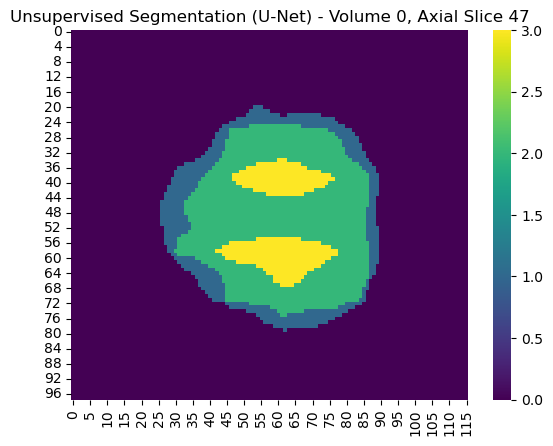

In [ ]:
sns_plot_3 = sns.heatmap(pred_seg_3[0][:, :, 47], cmap="viridis", cbar=True)
plt.title('Unsupervised Segmentation (U-Net) - Volume 0, Axial Slice 47')
plt.show()

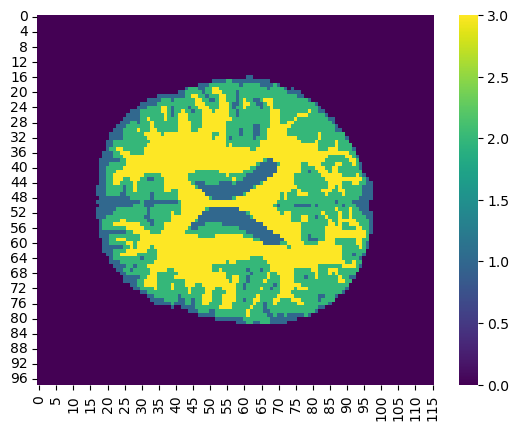

In [ ]:
sns_plot_gt = sns.heatmap(segmentations_test[0][:, :, 47], cmap="viridis", cbar=True)

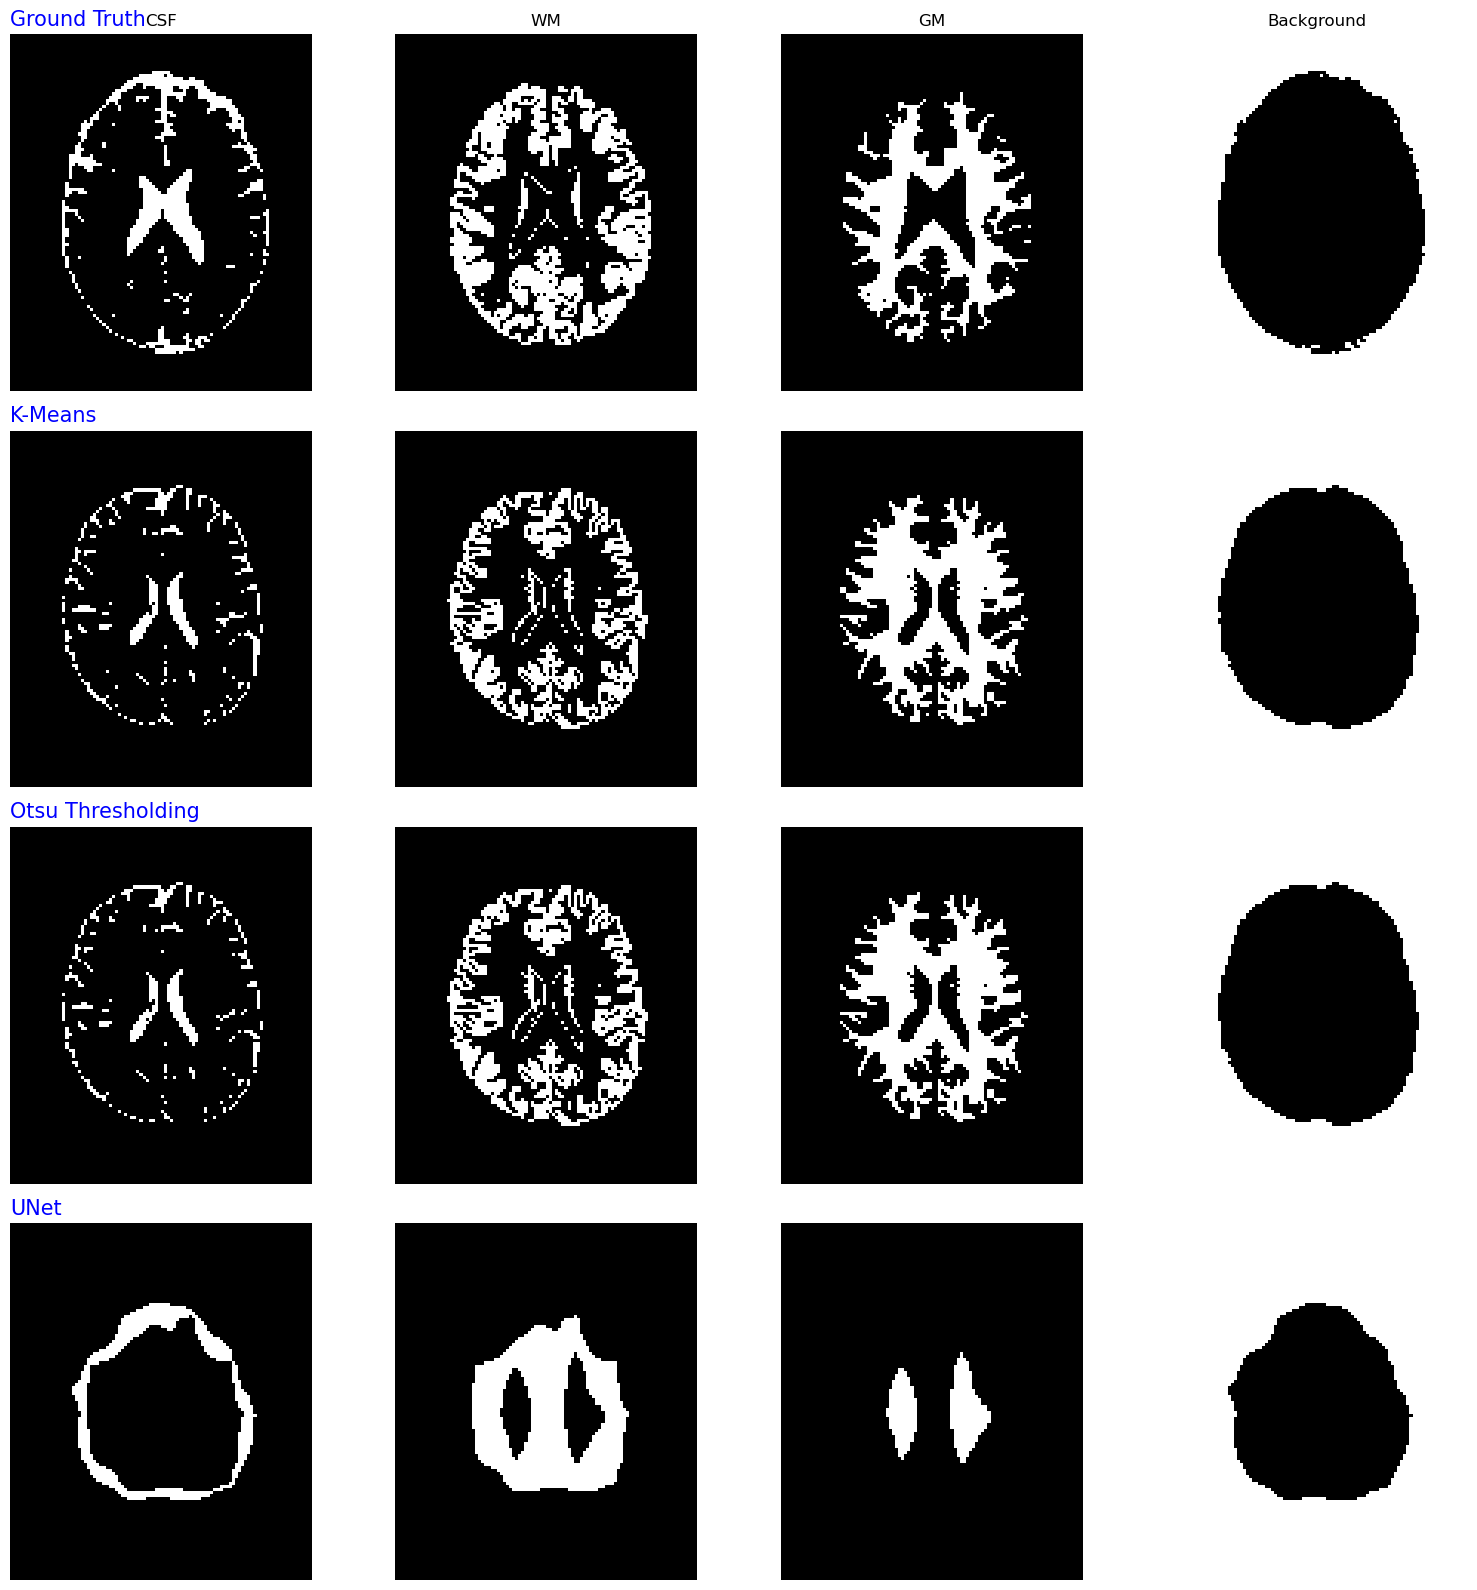

In [ ]:
def visualize_segments(segmentations, titles, subtitles):
    elements_list = []

    for seg in segmentations:
        csf, wm, gm, background = (
            np.zeros(seg.shape),
            np.zeros(seg.shape),
            np.zeros(seg.shape),
            np.zeros(seg.shape),
        )
        csf[seg == 1] = 1
        wm[seg == 2] = 1
        gm[seg == 3] = 1
        background[seg == 0] = 1
        elements_list.append([csf, wm, gm, background])

    num_elements = len(elements_list[0])

    fig, axarr = plt.subplots(len(segmentations), num_elements, figsize=(4 * num_elements, 4 * len(segmentations)))

    for row_idx, elements in enumerate(elements_list):
        for col_idx, ax in enumerate(axarr[row_idx]):
            ax.axis('off')
            el = np.squeeze(elements[col_idx][:, :, 47])
            ax.imshow(el.T, cmap='gray')

            # Set titles for the first row only
            if col_idx == 0:
                #ax.set_title(titles[col_idx])
                ax.set_title(subtitles[row_idx], fontsize=15, loc='left', color='blue')
            if row_idx == 0:
                ax.set_title(titles[col_idx])

    plt.tight_layout()
    plt.show()

# Example usage:
titles = ['CSF', 'WM', 'GM', 'Background']
subtitles = [ 'Ground Truth','K-Means', 'Otsu Thresholding', 'UNet']

visualize_segments([segmentations_val[0], pred_seg_1[0], pred_seg_2[0], pred_seg_3[0]], titles, subtitles)

In [ ]:
# Visualize individual segmentation channels for axial slice 47 of all three approaches and the ground truth in a similar style as above
# Implement
# --------------------------- ADD YOUR CODE HERE ------------------------------
plt_seg_1 = sns_plot_1
plt_seg_2 = sns_plot_2
plt_seg_3 = sns_plot_3
plt_gt = sns_plot_gt
# ----------------------------------- END -------------------------------------

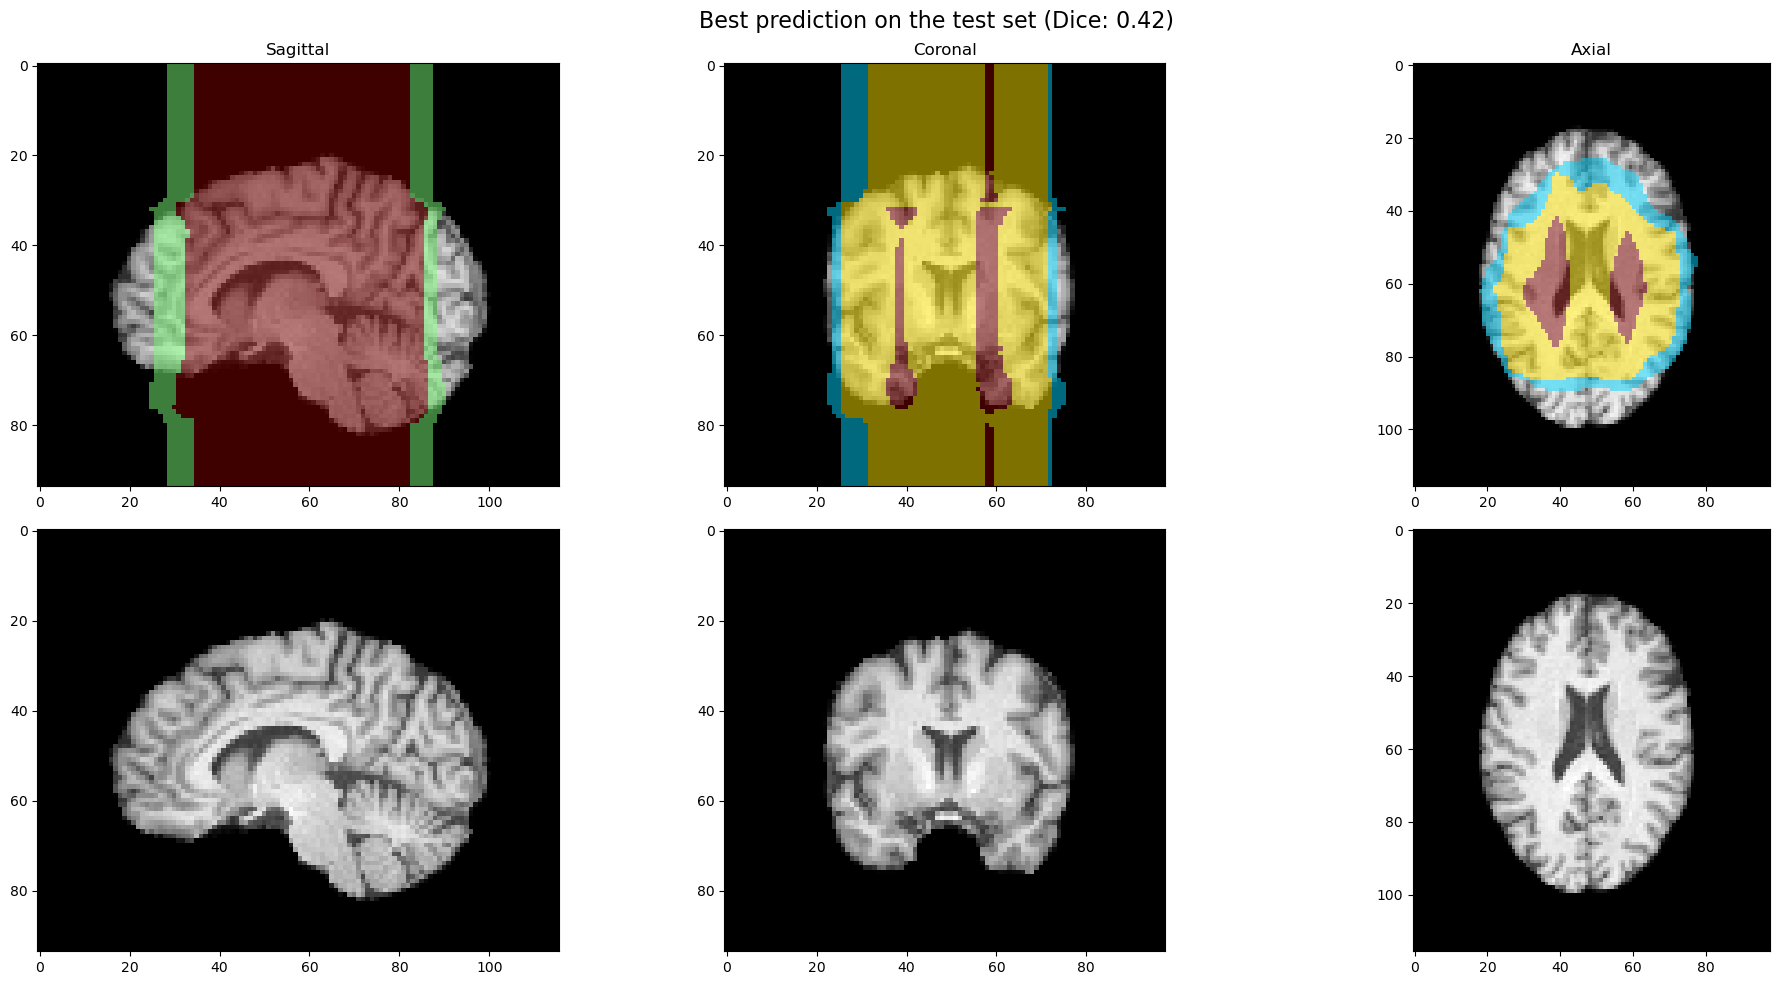

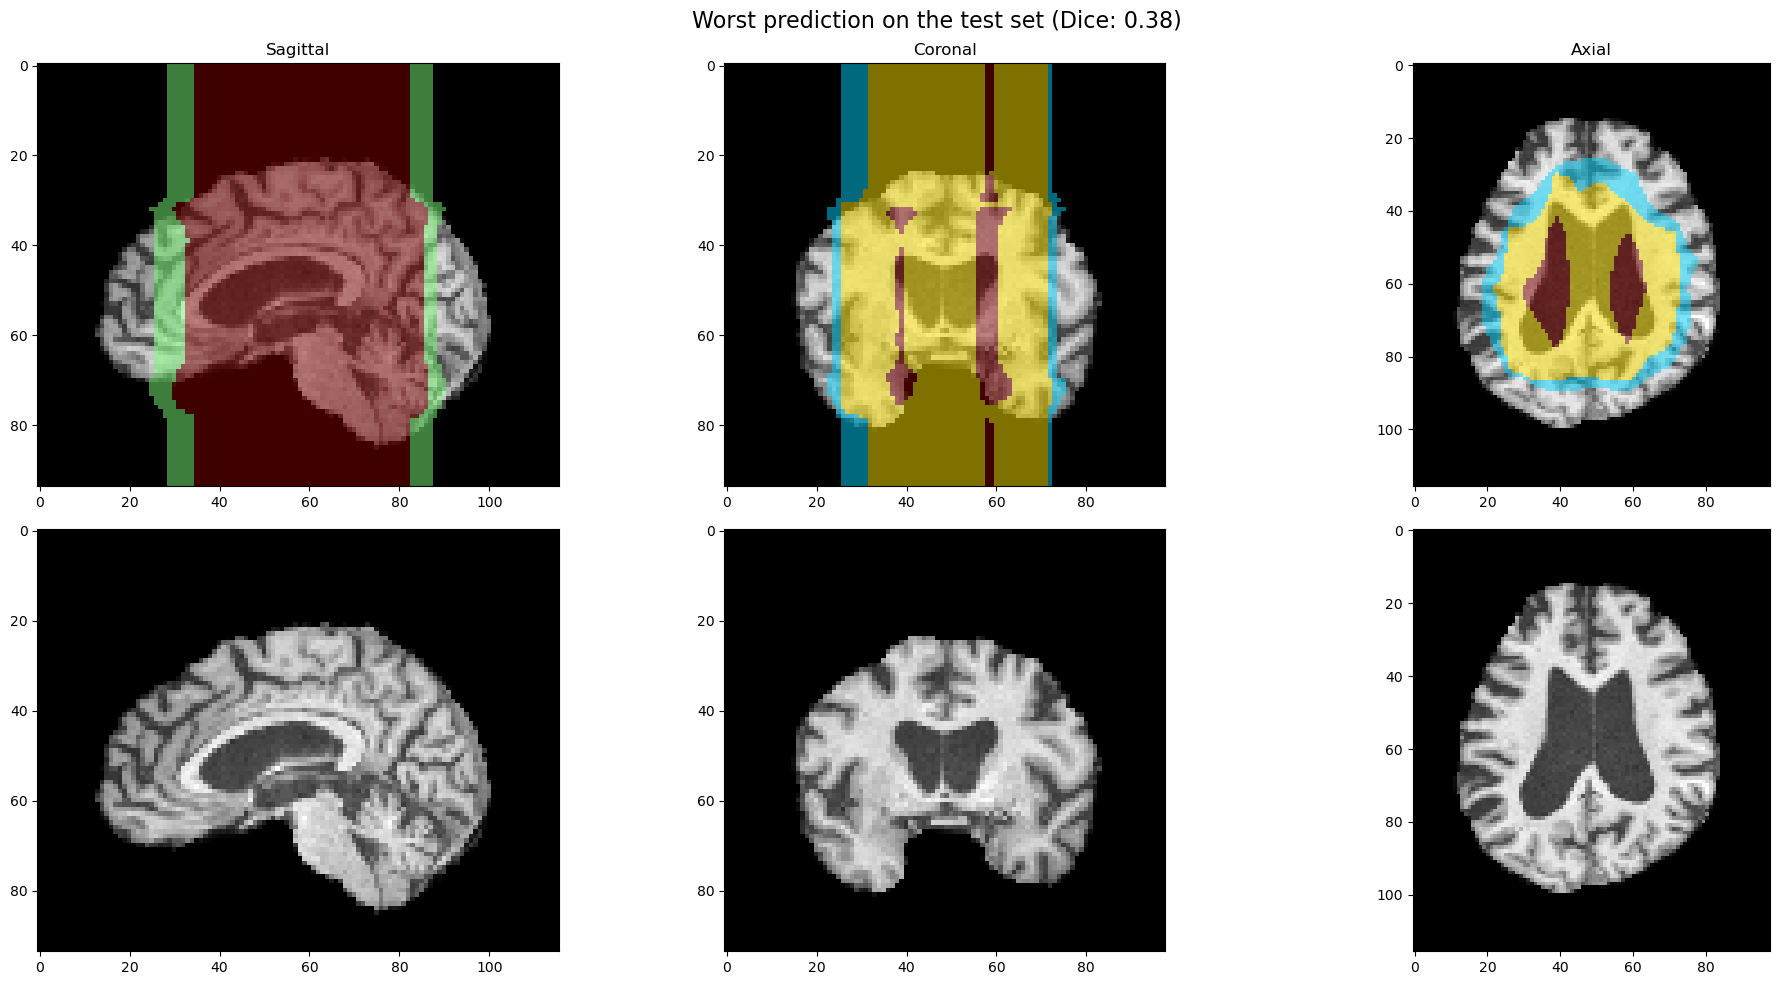

In [ ]:
# Run this block after implementing Q3.
visualize_best_and_worst_samples(pred_seg_3,segmentations_test,i_best=47,i_worst = 47)

### Summarize the results of all of the segmentation methods implemented.

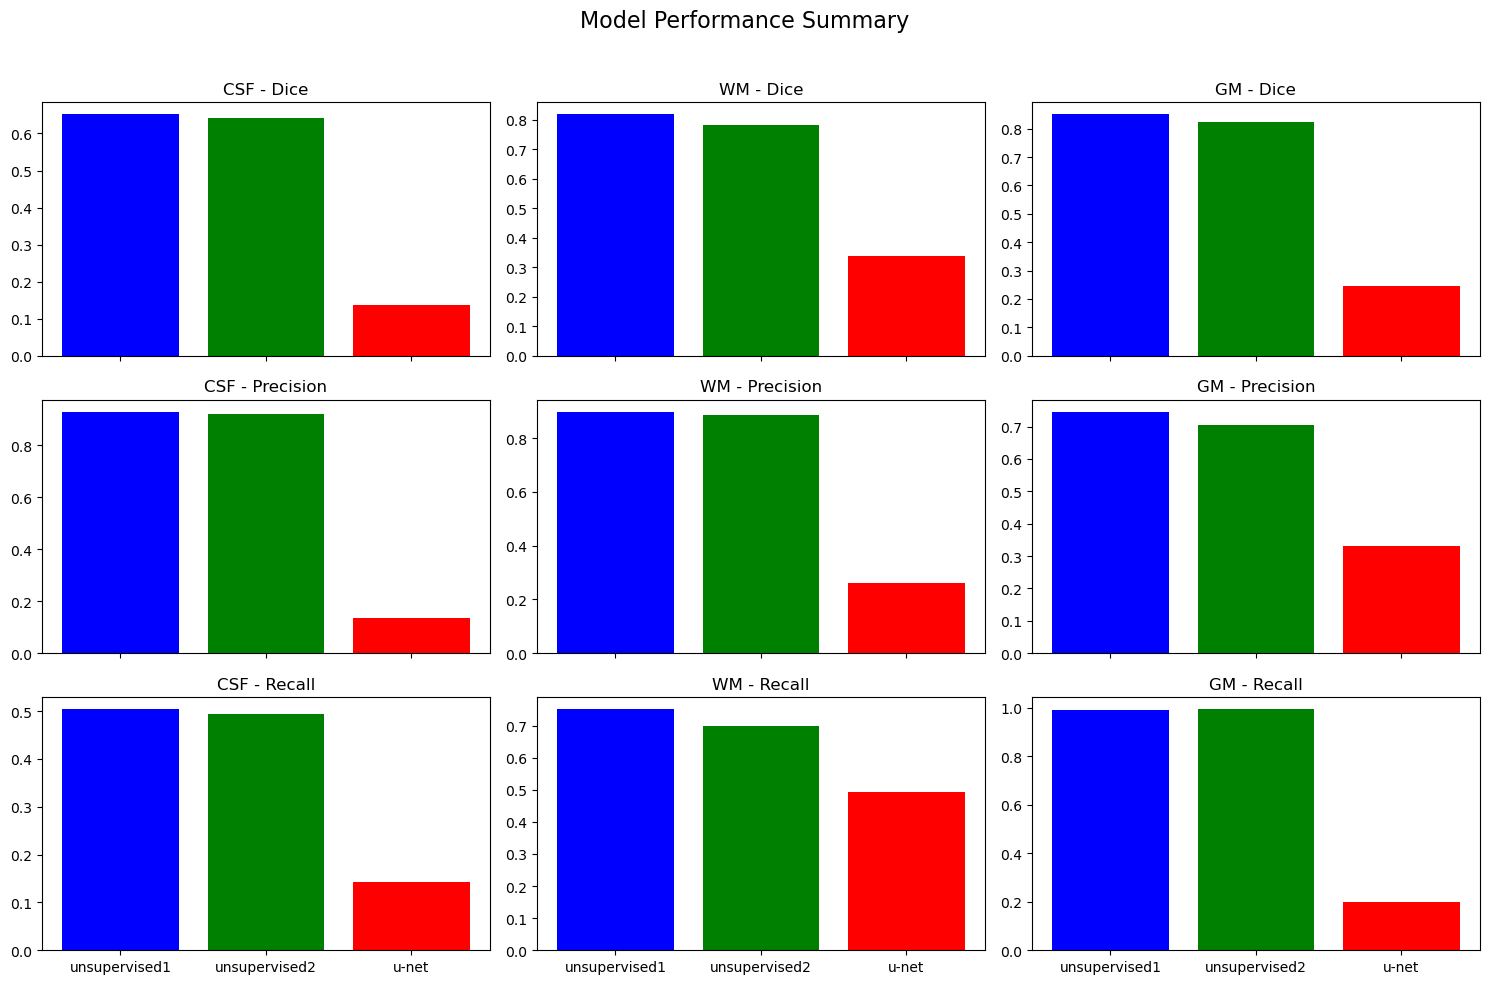

In [ ]:
# Run this block after implementing Q1-3.
results_dictionary = {
    'unsupervised1': get_results_dictionary(pred_seg_1,segmentations_test),
    'unsupervised2': get_results_dictionary(pred_seg_2,segmentations_test),
    'u-net': get_results_dictionary(pred_seg_3,segmentations_test),
}
plot_results_summary(results_dictionary)